# Pre-trained models and transfer learning

Training CNNs can take a lot of time, and a lot of data is required for that task. However, much of the time is spent to learn the best low-level filters that a network is using to extract patterns from images. A natural question arises - can we use a neural network trained on one dataset and adapt it to classifying different images without full training process?

This approach is called **transfer learning**, because we transfer some knowledge from one neural network model to another. In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, such as **ImageNet**. Those models can already do a good job extracting different features from generic images, and in many cases just building a classifier on top of those extracted features can yield a good result.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from tfcv import *

## Cats vs. Dogs Dataset

In this unit, we will solve a real-life problem of classifying images of cats and dogs. For this reason, we will use [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats), which can also be downloaded [from Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

Let's download this dataset and extract it into `data` directory (this process may take some time!):

In [2]:
if not os.path.exists('data/kagglecatsanddogs_3367a.zip'):
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

In [3]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_3367a.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

Unfortunately, there are some corrupt image files in the dataset. We need to do quick cleaning to check for corrupted files. In order not to clobber this tutorial, we moved the code to verify dataset into a module.

In [4]:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


## Loading the Dataset

In previous examples, we were loading datasets that are built into Keras. Now we are about to deal with our own dataset, which we need to load from a directory of images.

In real life, the size of image datasets can be pretty large, and one cannot rely on all data being able to fit into memory. Thus, datasets are often represented as **generators** that can return data in minibatches suitable for training.

To deal with image classification, Keras includes special function `image_dataset_from_directory`, which can load images from subdirectories corresponding to different classes. This function also takes care of scaling images, and it can also split dataset into train and test subsets:

In [2]:
data_dir = 'data/PetImages'
ds_train = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 13,
    image_size = (224,224),
    batch_size = 64
)
ds_test = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 13,
    image_size = (224,224),
    batch_size = 64
)

Found 24998 files belonging to 2 classes.
Using 19999 files for training.
Found 24998 files belonging to 2 classes.
Using 4999 files for validation.


It is important to set the same `seed` value for both calls, because it affects the split of images between train and test dataset.

Dataset automatically picks up class names from directories, and you can access them if needed by calling:

In [3]:
ds_train.class_names

['Cat', 'Dog']

Datasets that we have obtained can be directly passed to `fit` function to train the model. They contain both corresponding images and labels, which can be looped over using the following construction:

Training batch shape: features=(64, 224, 224, 3), labels=(64,)


/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


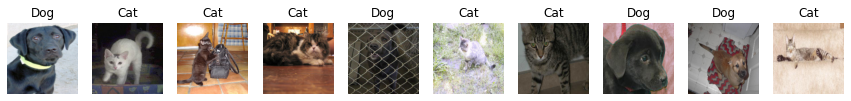

In [4]:
for x,y in ds_train:
    print(f"Training batch shape: features={x.shape}, labels={y.shape}")
    x_sample, y_sample = x,y
    break
    
display_dataset(x_sample.numpy().astype(np.int),np.expand_dims(y_sample,1),classes=ds_train.class_names)

> **Note**: All images in the dataset are represented as floatint point tensors with range 0-255. Before passing them to the neural network, we need to scale those values into 0-1 range. When plotting images, we either need to do the same, or convert values to the `int` type (which we do in the code above), in order to show `matplotlib` that we want to plot the original unscaled image.

## Pre-trained models

For many image classification tasks one can find pre-trained neural network models. Many of those models are available inside `keras.applications` namespace, and even more models can be found on the Internet. Let's see how simplest VGG-16 model can be loaded and used:

In [5]:
vgg = keras.applications.VGG16()
inp = keras.applications.vgg16.preprocess_input(x_sample[:1])

res = vgg(inp)
print(f"Most probable class = {tf.argmax(res,1)}")

keras.applications.vgg16.decode_predictions(res.numpy())

Most probable class = [208]


[[('n02099712', 'Labrador_retriever', 0.5407993),
  ('n02100236', 'German_short-haired_pointer', 0.09200565),
  ('n02092339', 'Weimaraner', 0.08032639),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.05759483),
  ('n02109047', 'Great_Dane', 0.03761804)]]

There are a couple of important things here:
* Before passing an input to any pre-trained network it has to be pre-processed in a certain way. This is done by calling corresponding `preprocess_input` function, which receives a batch of images, and returns their processed form. In the case of VGG-16, images are normalized, and some pre-defined avarage value for each channels is subtracted. That is because VGG-16 was originally trained with this pre-processing.
* Neural network is applied to the input batch, and we receive as the result a batch of 1000-element tensors that show probability of each class. We can find the most probable class number by calling `argmax` on this tensor.
* Obtained result is a [number of an `ImageNet` class](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). To make sense of this result, we can also use `decode_predictions` function, that returns top n classes together with their names.

Let's also see the architecture of the VGG-16 network:

In [6]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## GPU computations

Deep neural networks, such as VGG-16 and other more modern architectures require quite a lot of computational power to run. It makes sense to use GPU acceleration, if it is available. Luckily, Keras automatically speeds up the computatons on the GPU if it is available. We can check if Tensorflow is able to use GPU using the following code:

In [2]:
tf.config.list_physical_devices('GPU')

[]


## Extracting VGG features

If we want to use VGG-16 to extract features from our images, we need the model without final classification layers. We can instantiate VGG-16 model without top layers using this code:

In [ ]:
vgg = keras.applications.VGG16(include_top=False)

inp = keras.applications.vgg16.preprocess_input(x_sample[:1])
res = vgg(inp)
print(res.shape)
#plt.figure(figsize=(15,3))
#plt.imshow(res.detach().view(-1,512))
#print(res.size())

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-e5f54a53435f>", line 3, in <module>
    inp = keras.applications.vgg16.preprocess_input(x_sample[:1])
NameError: name 'x_sample' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1169, in get_records
    return _fixed_getinnerframes(etb, number_of_

The dimension of feature tensor is 512x7x7, but in order to visualize it we had to reshape it to 2D form.

Now let's try to see if those features can be used to classify images. Let's manually take some portion of images (800 in our case), and pre-compute their feature vectors. We will store the result in one big tensor called `feature_tensor`, and also labels into `label_tensor`:

In [13]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break


....................................................................................................

Now we can define `vgg_dataset` that takes data from this tensor, split it into training and test sets using `random_split` function, and train a small one-layer dense classifier network on top of extracted features:

In [14]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(device)

history = train(net,train_loader,test_loader)

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch  0, Train acc=0.859, Val acc=0.980, Train loss=0.151, Val loss=0.048
Epoch  1, Train acc=0.984, Val acc=0.990, Train loss=0.018, Val loss=0.006
Epoch  2, Train acc=0.989, Val acc=0.960, Train loss=0.014, Val loss=0.109
Epoch  3, Train acc=0.997, Val acc=0.980, Train loss=0.003, Val loss=0.028
Epoch  4, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.022
Epoch  5, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.022
Epoch  6, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.023
Epoch  7, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.023
Epoch  8, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.024
Epoch  9, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.024


The result is great, we can distinguish between a cat and a dog with almost 98% probability! However, we have only tested this approach on a small subset of all images, because manual feature extraction seems to take a lot of time.

## Transfer learning using one VGG network

We can also avoid manually pre-computing the features by using the original VGG-16 network as a whole during training. Let's look at the VGG-16 object structure:

In [15]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

You can see that the network contains:
* feature extractor (`features`), comprised of a number of convolutional and pooling layers
* average pooling layer (`avgpool`)
* final `classifier`, consisting of several dense layers, which turns 25088 input features into 1000 classes (which is the number of classes in ImageNet)

To train the end-to-end model that will classify our dataset, we need to:
* **replace the final classifier** with the one that will produce required number of classes. In our case, we can use one `Linear` layer with 25088 inputs and 2 output neurons.
* **freeze weights of convolutional feature extractor**, so that they are not trained. It is recommended to initially do this freezing, because otherwise untrained classifier layer can destroy the original pre-trained weights of convolutional extractor. Freezing weights can be accomplished by setting `requires_grad` property of all parameters to `False`

In [16]:
vgg.classifier = torch.nn.Linear(25088,2).to(device)

for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg,(1, 3,244,244))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

As you can see from the summary, this model contain around 15 million total parameters, but only 50k of them are trainable - those are the weights of classification layer. That is good, because we are able to fine-tune smaller number of parameters with smaller number of examples.

Now let's train the model using our original dataset. This process will take a long time, so we will use `train_long` function that will print some intermediate results without waiting for the end of epoch. It is highly recommended to run this training on GPU-enabled compute!

In [17]:
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.5625, train loss = 0.045165419578552246
Epoch 0, minibatch 90: train acc = 0.945054945054945, train loss = 0.10654432694990557
Epoch 0, minibatch 180: train acc = 0.9558011049723757, train loss = 0.10983258452863325
Epoch 0, minibatch 270: train acc = 0.9612546125461254, train loss = 0.11056054034356262
Epoch 0, minibatch 360: train acc = 0.9657202216066482, train loss = 0.09974451672667611
Epoch 0, minibatch 450: train acc = 0.9667405764966741, train loss = 0.10326384652215996
Epoch 0, minibatch 540: train acc = 0.9695009242144177, train loss = 0.1081675954314565


/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/PIL/TiffImagePlugin

Epoch 0, minibatch 630: train acc = 0.9695919175911252, train loss = 0.11688086121282562
Epoch 0, minibatch 720: train acc = 0.9707871012482663, train loss = 0.1197152633772809
Epoch 0, minibatch 810: train acc = 0.9708692971639951, train loss = 0.12544860087252427
Epoch 0, minibatch 900: train acc = 0.9710044395116537, train loss = 0.1342598833598519
Epoch 0, minibatch 990: train acc = 0.972061049445005, train loss = 0.13815826508399817
Epoch 0, minibatch 1080: train acc = 0.9726526364477336, train loss = 0.140142435502609
Epoch 0, minibatch 1170: train acc = 0.9720858240819812, train loss = 0.15663393250293553
Epoch 0 done, validation acc = 0.9817927170868347, validation loss = 0.15710224519495297


It looks like we have obtained reasonably accurate cats vs. dogs classifier! Let's save it for future use!

In [18]:
torch.save(vgg,'data/cats_dogs.pth')

We can then load the model from file at any time. You may find it useful in case the next experiment destroys the model - you would not have to re-start from scratch.

In [19]:
vgg = torch.load('data/cats_dogs.pth')

## Fine-tuning transfer learning

In the previous section, we have trained the final classifier layer to classify images in our own dataset. However, we did not re-train the feature extractor, and our model relied on the features that the model has learned on ImageNet data. If your objects visually differ from ordinary ImageNet images, this combination of features might not work best. Thus it makes sense to start training convolutional layers as well.

To do that, we can unfreeze the convolutional filter parameters that we have previously frozen. 

> **Note:** It is important that you freeze parameters first and perform several epochs of training in order to stabilize weights in the classification layer. If you immediately start training end-to-end network with unfrozen parameters, large errors are likely to destroy the pre-trained weights in the convolutional layers.

In [20]:
for x in vgg.features.parameters():
    x.requires_grad = True

After unfreezing, we can do a few more epochs of training. You can also select lower learning rate, in order to minimize the impact on the pre-trained weights. However, even with low learning rate, you can expect the accuracy to drop in the beginning of the training, until finally reaching slightly higher level than in the case of fixed weights.

> **Note:** This training happens much slower, because we need to propagate gradients back through many layers of the network! You may want to watch the first few minibatches to see the tendency, and then stop the computation.

In [21]:
train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90,lr=0.0001)

Epoch 0, minibatch 0: train acc = 0.9375, train loss = 0.05164256691932678
Epoch 0, minibatch 90: train acc = 0.9237637362637363, train loss = 0.22198507288000086
Epoch 0, minibatch 180: train acc = 0.9350828729281768, train loss = 0.1316179834018096
Epoch 0, minibatch 270: train acc = 0.9446494464944649, train loss = 0.09719027980227311
Epoch 0, minibatch 360: train acc = 0.9510041551246537, train loss = 0.07776963083367598
Epoch 0, minibatch 450: train acc = 0.9542682926829268, train loss = 0.0652109091139157
Epoch 0, minibatch 540: train acc = 0.9554066543438078, train loss = 0.057144408305339144
Epoch 0, minibatch 630: train acc = 0.9562202852614897, train loss = 0.051035371710872496
Epoch 0, minibatch 720: train acc = 0.9535367545076283, train loss = 0.048412391778996186
Epoch 0, minibatch 810: train acc = 0.9558415536374846, train loss = 0.043707310197973664
Epoch 0, minibatch 900: train acc = 0.9573390677025527, train loss = 0.04010265490058789
Epoch 0, minibatch 990: train acc 

## Other computer vision models

VGG-16 is one of the simplest computer vision architectures. `torchvision` package provides many more pre-trained networks. The most frequently used ones among those are **ResNet** architectures, developed by Microsoft, and **Inception** by Google. For example, let's explore the architecture of the simplest ResNet-18 model (ResNet is a family of models with different depth, you can try experimenting with ResNet-151 if you want to see what a really deep model looks like):

In [22]:
resnet = torchvision.models.resnet18()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

As you can see, the model contains the same building blocks: feature extractor and final classifier (`fc`). This allows us to use this model in exactly the same manner as we have been using VGG-16 for transfer learning. You can try experimenting with the code above, using different ResNet models as the base model, and see how accuracy changes.

This network contains yet another type of layer: **Batch Normalization**. The idea of batch normalization is to bring values that flow through the neural network to right interval. Usually neural networks work best when all values are in the range of [-1,1] or [0,1], and that is the reason that we scale/normalize our input data accordingly. However, during training of multi-level network

## Takeaway

Using transfer learning, we were able to quickly put together a classifier for our custom object classification task, and achieve high accuracy. However, this example was not completely fair, because original VGG-16 network was pre-trained to recognize cats and dogs, and thus we were just reusing most of the patterns that were already present in the network. You can expect lower accuracy on more exotic domain-specific objects, such as details on production line in a plant, or different tree leaves.

You can see that more complex tasks that we are solving now require higher computational power, and cannot be easily solved on the CPU. In the next unit, we will try to use more lightweight implementation to train the same model using lower compute resources, which results in just slightly lower accuracy. 